In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/baikal_temperature.csv')
df['date']=pd.to_datetime(df['date'])

df.head()

,date,temp
0,2014-01-01,-16.43
1,2014-01-02,-13.87
2,2014-01-03,-15.70
3,2014-01-04,-18.86
4,2014-01-05,-18.57


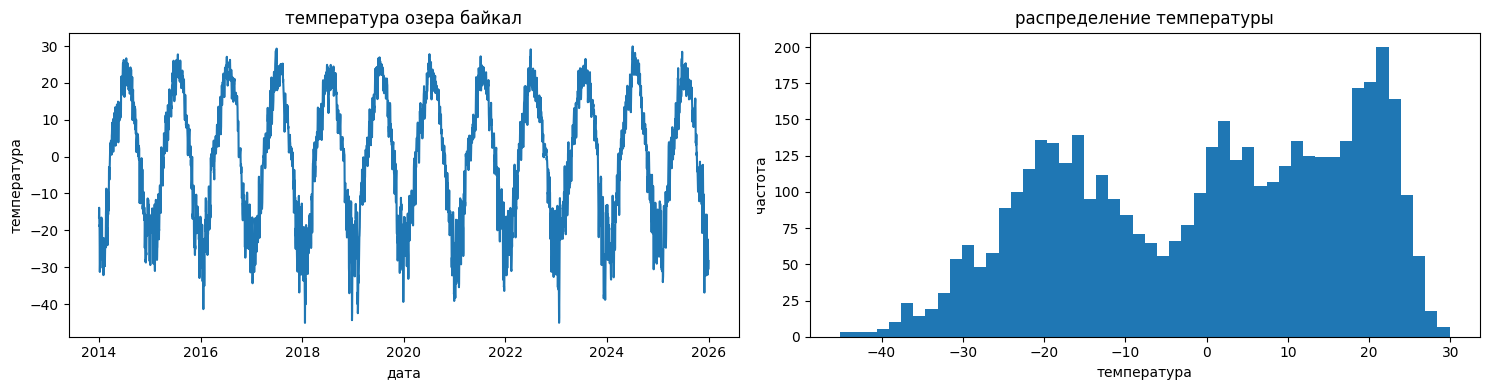

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,axes=plt.subplots(1,2,figsize=(15,4))

axes[0].plot(df['date'],df['temp'])
axes[0].set_xlabel('дата')
axes[0].set_ylabel('температура')
axes[0].set_title('температура озера байкал')

axes[1].hist(df['temp'].dropna(),bins=50,)
axes[1].set_xlabel('температура')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение температуры')

plt.tight_layout()
plt.show()

In [3]:
df['temp_diff24']=df['temp']-df['temp'].shift(1) # изменение температуры за 24ч
df['temp_diff48']=df['temp']-df['temp'].shift(2) # изменение температуры за 48ч
df['amplitude_3d']=df['temp'].rolling(3).max() - df['temp'].rolling(3).min() # амплитуда температуры за 3 дня

#определяем фронты
cold=df['temp_diff24']<-10 #холодные фронты движутся быстрее и имеют крутой наклон
warm=(df['temp_diff48']>6)&(df['temp']<-5)&(~cold) #теплые фронты медленне и имеют пологий наклон
stat=(df['amplitude_3d'].between(0.1,2))&(~cold)&(~warm) # стац. фронт - воздущные массы "застыли" - нет существенного движения

df['front']=(cold | warm | stat).astype(int)

#целевая переменная: будет ли завтра фронт
df['target']=df['front'].shift(-1)
df=df.dropna()
df

,date,temp,temp_diff24,temp_diff48,amplitude_3d,front,target
2,2014-01-03,-15.70,-1.83,0.73,2.56,0,0.0
3,2014-01-04,-18.86,-3.16,-4.99,4.99,0,0.0
4,2014-01-05,-18.57,0.29,-2.87,3.16,0,0.0
5,2014-01-06,-27.90,-9.33,-9.04,9.33,0,0.0
6,2014-01-07,-31.28,-3.38,-12.71,12.71,0,0.0
...,...,...,...,...,...,...,...
4377,2025-12-26,-22.45,7.58,9.63,9.63,1,1.0
4378,2025-12-27,-22.51,-0.06,7.52,7.58,1,0.0
4379,2025-12-28,-25.64,-3.13,-3.19,3.19,0,0.0
4380,2025-12-29,-30.58,-4.94,-8.07,8.07,0,0.0


In [4]:
df['day_of_year']=df['date'].dt.day_of_year
df['weekday']=df['date'].dt.day_of_week
df['month']=df['date'].dt.month

#преобразуем шкалу дней (1-365) в годовой цикл (круг)
df['sin_day']=np.sin(2*np.pi *df['day_of_year']/365.25)
df['cos_day']=np.cos(2*np.pi *df['day_of_year']/365.25)

for i in range(1,4):
  df[f'temp_{i}days_ago']=df['temp'].shift(i)

df['temp_avg_3d']=df['temp'].rolling(3).mean()
df['temp_std_3d']=df['temp'].rolling(3).std()

df['cold_season']=(df['month'].isin([11,12,1,2,3])).astype(int)

# дополнительные признаки на основе анализа важности:
# temp_diff24 самый важный признак (41%), усиливаем его информативность

df['temp_change_abs']=df['temp_diff24'].abs()
df['change_std']=df['temp_diff24']*df['temp_std_3d']
df['change_amplitude']=df['temp_diff24']*df['amplitude_3d']
df['change_season']=df['temp_diff24']*df['sin_day']

df.isna().sum().sum()

np.int64(12)

In [5]:
df=df.dropna()
df

,date,temp,temp_diff24,temp_diff48,amplitude_3d,front,target,day_of_year,weekday,month,...,temp_1days_ago,temp_2days_ago,temp_3days_ago,temp_avg_3d,temp_std_3d,cold_season,temp_change_abs,change_std,change_amplitude,change_season
5,2014-01-06,-27.90,-9.33,-9.04,9.33,0,0.0,6,0,1,...,-18.57,-18.86,-15.70,-21.776667,5.304944,1,9.33,-49.495130,-87.0489,-0.961283
6,2014-01-07,-31.28,-3.38,-12.71,12.71,0,0.0,7,1,1,...,-27.90,-18.57,-18.86,-25.916667,6.583026,1,3.38,-22.250628,-42.9598,-0.406026
7,2014-01-08,-29.17,2.11,-1.27,3.38,0,1.0,8,2,1,...,-31.28,-27.90,-18.57,-29.450000,1.707308,1,2.11,3.602420,7.1318,0.289461
8,2014-01-09,-20.09,9.08,11.19,11.19,1,1.0,9,3,1,...,-29.17,-31.28,-27.90,-26.846667,5.945791,1,9.08,53.987784,101.6052,1.400173
9,2014-01-10,-20.68,-0.59,8.49,9.08,1,0.0,10,4,1,...,-20.09,-29.17,-31.28,-23.313333,5.080594,1,0.59,-2.997550,-5.3572,-0.100994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,2025-12-26,-22.45,7.58,9.63,9.63,1,1.0,360,4,12,...,-30.03,-32.08,-25.14,-28.186667,5.072734,1,7.58,38.451326,72.9954,-0.683640
4378,2025-12-27,-22.51,-0.06,7.52,7.58,1,0.0,361,5,12,...,-22.45,-30.03,-32.08,-24.996667,4.359098,1,0.06,-0.261546,-0.4548,0.004383
4379,2025-12-28,-25.64,-3.13,-3.19,3.19,0,0.0,362,6,12,...,-22.51,-22.45,-30.03,-23.533333,1.824673,1,3.13,-5.711228,-9.9847,0.174901
4380,2025-12-29,-30.58,-4.94,-8.07,8.07,0,0.0,363,0,12,...,-25.64,-22.51,-22.45,-26.243333,4.068689,1,4.94,-20.099326,-39.8658,0.191157


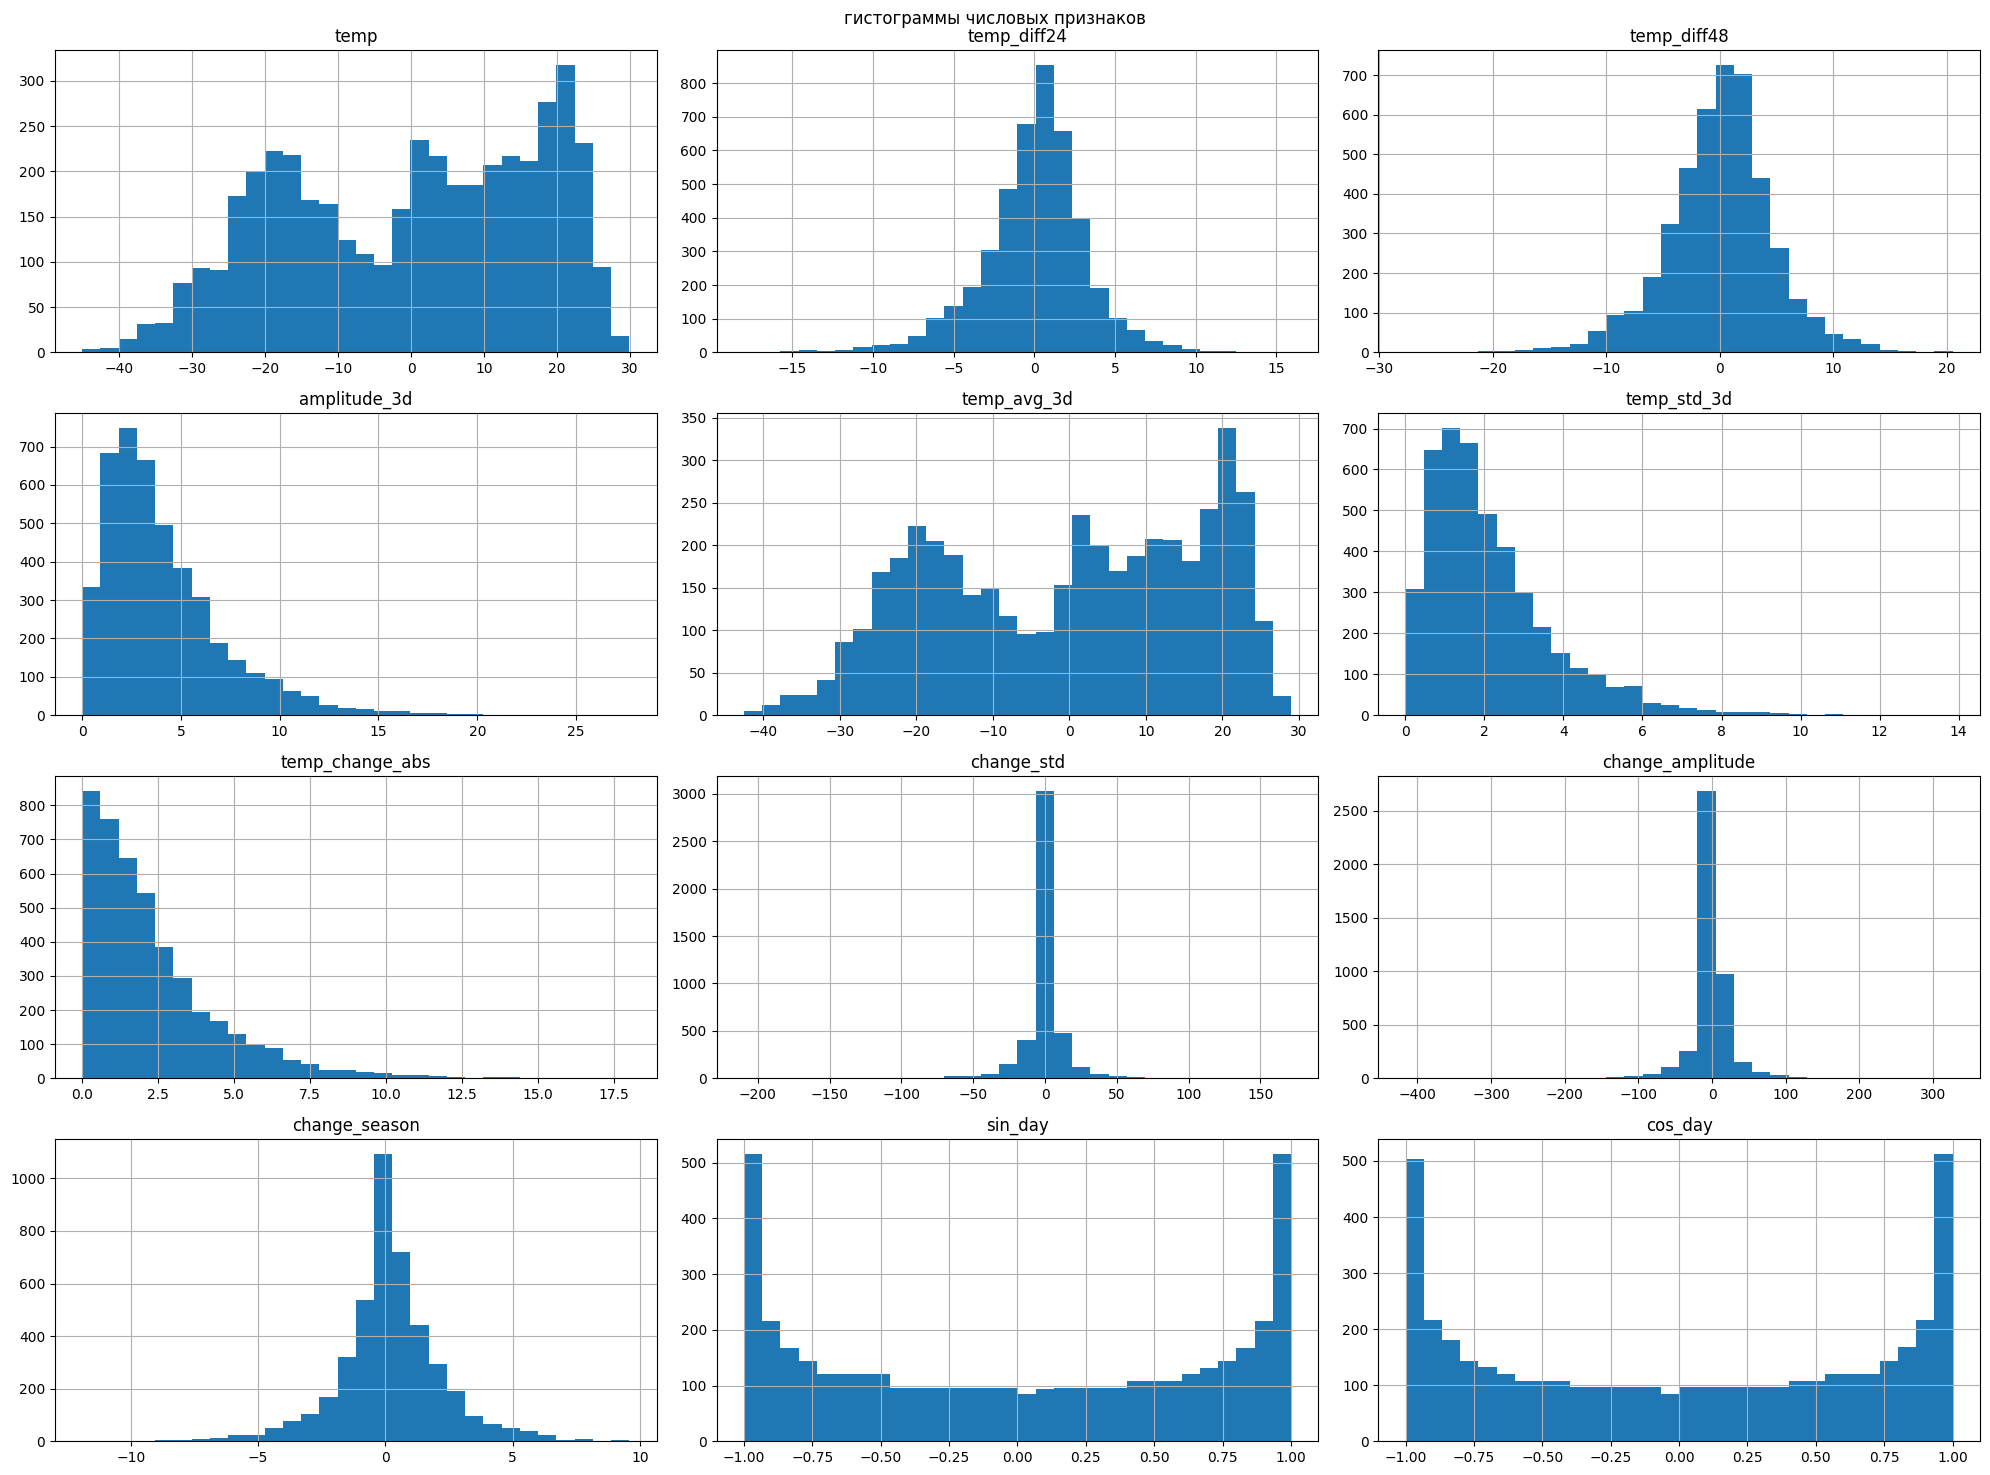

In [6]:
num_features=['temp', 'temp_diff24', 'temp_diff48', 'amplitude_3d',
              'temp_avg_3d', 'temp_std_3d', 'temp_change_abs',
              'change_std', 'change_amplitude', 'change_season',
              'sin_day', 'cos_day']

df[num_features].hist(bins=30,figsize=(20,15))
plt.suptitle('гистограммы числовых признаков')
plt.tight_layout()
plt.show()

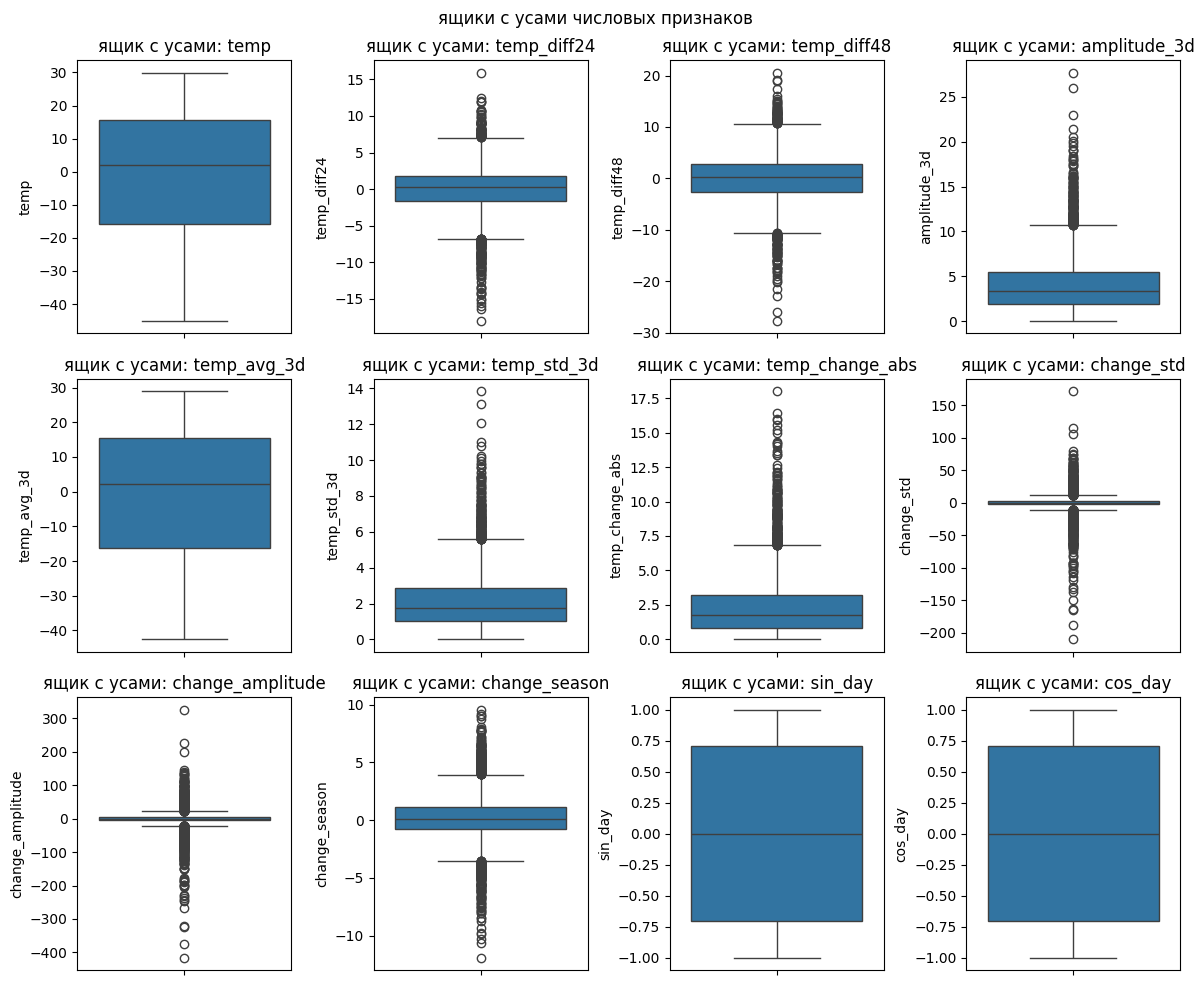

In [7]:

plt.figure(figsize=(12,10))
for i,col in enumerate(num_features,1):
  plt.subplot(3,4,i)
  sns.boxplot(data=df,y=col)
  plt.title(f'ящик с усами: {col}')
plt.suptitle('ящики с усами числовых признаков')
plt.tight_layout()
plt.show()

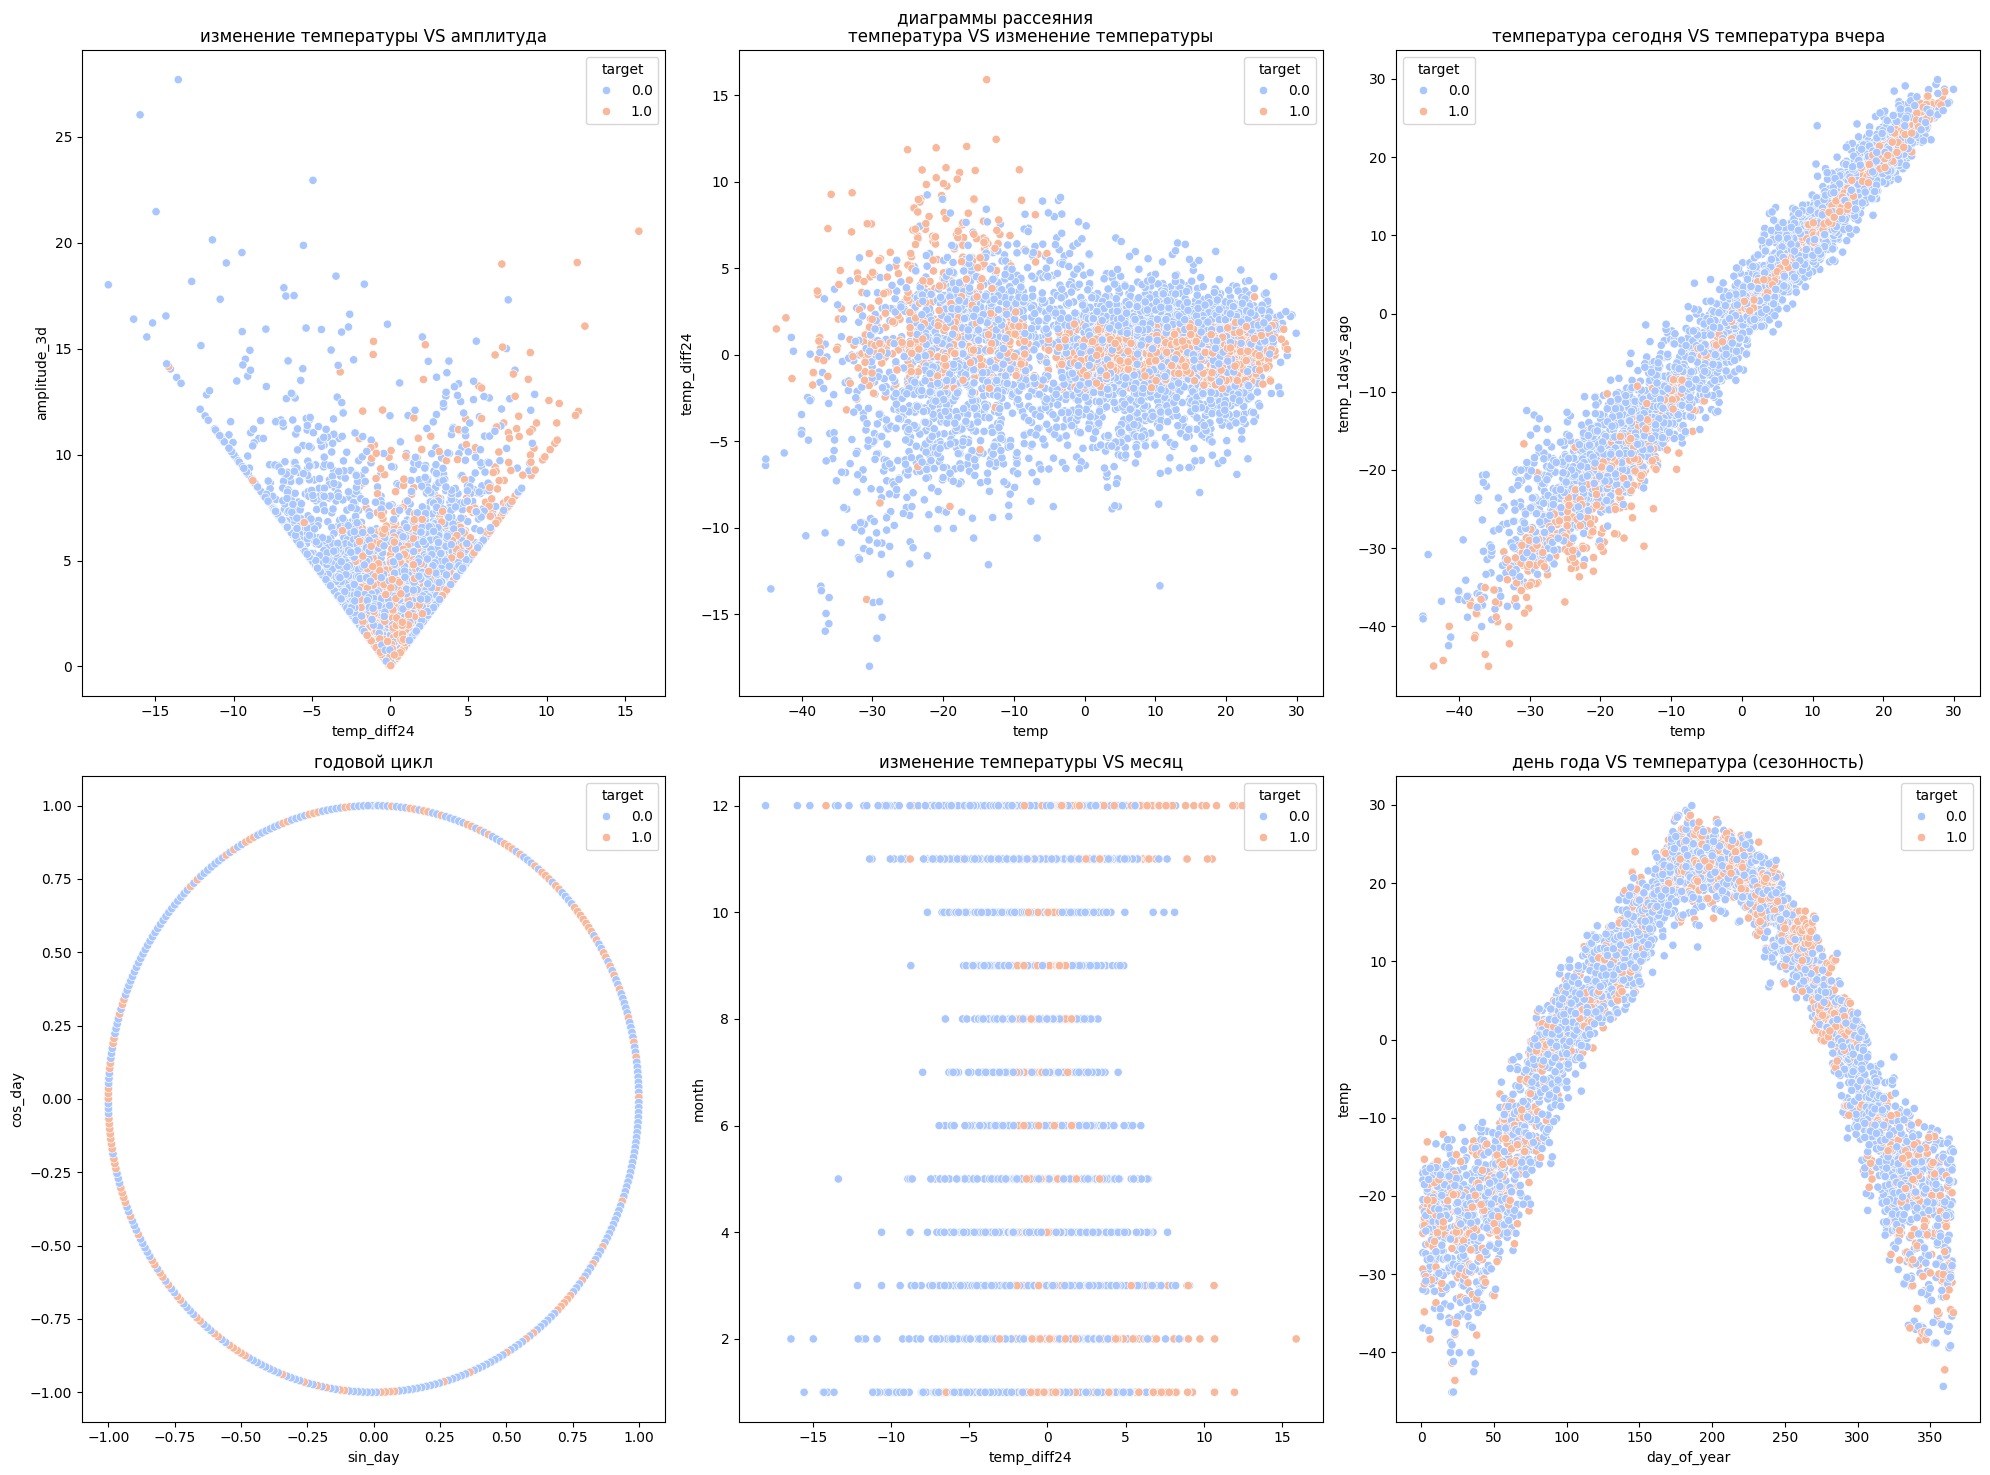

In [8]:
plt.figure(figsize=(20,15))

plt.subplot(2,3,1)
sns.scatterplot(data=df,x='temp_diff24',y='amplitude_3d',hue='target',palette='coolwarm')
plt.title('изменение температуры VS амплитуда')

plt.subplot(2,3,2)
sns.scatterplot(data=df,x='temp',y='temp_diff24',hue='target',palette='coolwarm')
plt.title('температура VS изменение температуры')

plt.subplot(2,3,3)
sns.scatterplot(data=df,x='temp',y='temp_1days_ago',hue='target',palette='coolwarm')
plt.title('температура сегодня VS температура вчера')

plt.subplot(2,3,4)
sns.scatterplot(data=df,x='sin_day',y='cos_day',hue='target',palette='coolwarm')
plt.title('годовой цикл')

plt.subplot(2,3,5)
sns.scatterplot(data=df,x='temp_diff24',y='month',hue='target',palette='coolwarm')
plt.title('изменение температуры VS месяц')

plt.subplot(2,3,6)
sns.scatterplot(data=df,x='day_of_year',y='temp',hue='target',palette='coolwarm')
plt.title('день года VS температура (сезонность)')

plt.suptitle('диаграммы рассеяния')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'матрица корреляций')

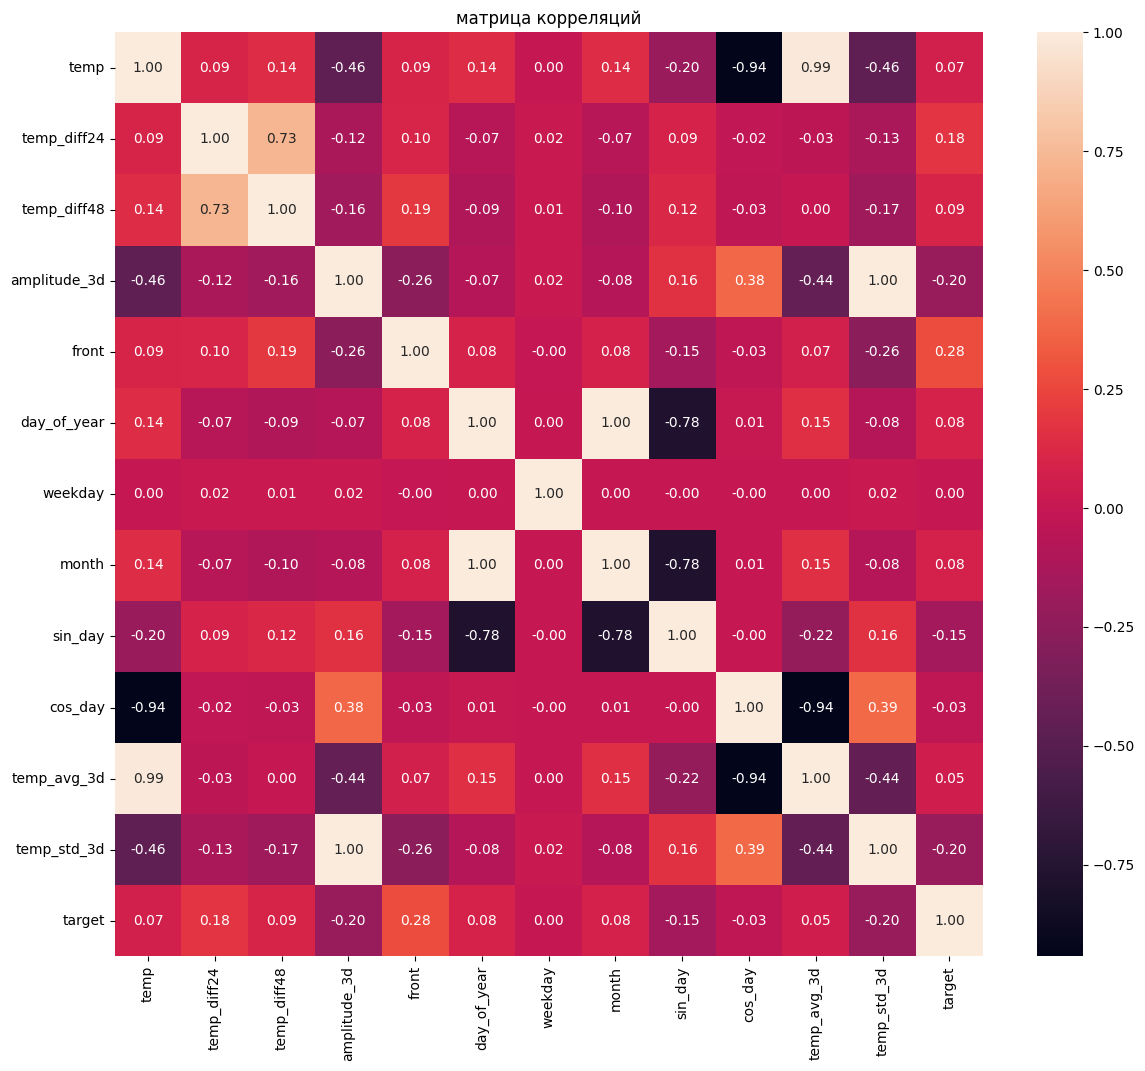

In [9]:
features_corr = ['temp', 'temp_diff24', 'temp_diff48', 'amplitude_3d',
                     'front', 'day_of_year', 'weekday', 'month','sin_day',
                     'cos_day', 'temp_avg_3d', 'temp_std_3d','target']

corr_matrix=df[features_corr].corr()

plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True,fmt='.2f')
plt.title('матрица корреляций')

In [10]:
print('топ-10 признаков по корреляции:')
t=corr_matrix['target'].abs().sort_values(ascending=False)[1:11]
print(t)

топ-10 признаков по корреляции:
front           0.276186
amplitude_3d    0.204800
temp_std_3d     0.200141
temp_diff24     0.178937
sin_day         0.152587
temp_diff48     0.094841
day_of_year     0.082202
month           0.081175
temp            0.072621
temp_avg_3d     0.053343
Name: target, dtype: float64


In [11]:
from sklearn.preprocessing import StandardScaler

features=['temp','temp_diff24','amplitude_3d','sin_day','cos_day',
          'month','temp_avg_3d','temp_std_3d','temp_1days_ago',
        	'temp_2days_ago',	'temp_3days_ago', 'temp_change_abs',
          'change_std', 'change_amplitude']

X=df[features]
y=df['target']

split_date=df['date'].quantile(0.8)
train_mask=df['date']<=split_date

X_train=X[train_mask]
y_train=y[train_mask]
X_test=X[~train_mask]
y_test=y[~train_mask]

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

print(f'обучающая выборка: {X_train.shape[0]}')
print(f'тестовая выборка: {X_test.shape[0]}')

обучающая выборка: 3501
тестовая выборка: 876


In [15]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print('RandomForest:')
print(classification_report(y_test, y_pred_rf))

scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, scale_pos_weight=scale_pos_weight, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print('\nXGBoost:')
print(classification_report(y_test, y_pred_xgb))

lr=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr=lr.predict(X_test)
print('\nLogistic Regression:')
print(classification_report(y_test, y_pred_lr))

RandomForest:
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81       591
         1.0       0.61      0.50      0.55       285

    accuracy                           0.73       876
   macro avg       0.70      0.67      0.68       876
weighted avg       0.72      0.73      0.73       876


XGBoost:
              precision    recall  f1-score   support

         0.0       0.84      0.74      0.78       591
         1.0       0.56      0.71      0.63       285

    accuracy                           0.73       876
   macro avg       0.70      0.72      0.71       876
weighted avg       0.75      0.73      0.73       876


Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       591
         1.0       0.36      0.33      0.35       285

    accuracy                           0.59       876
   macro avg       0.53      0.53      0.53       876
weighted avg       0.58     

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


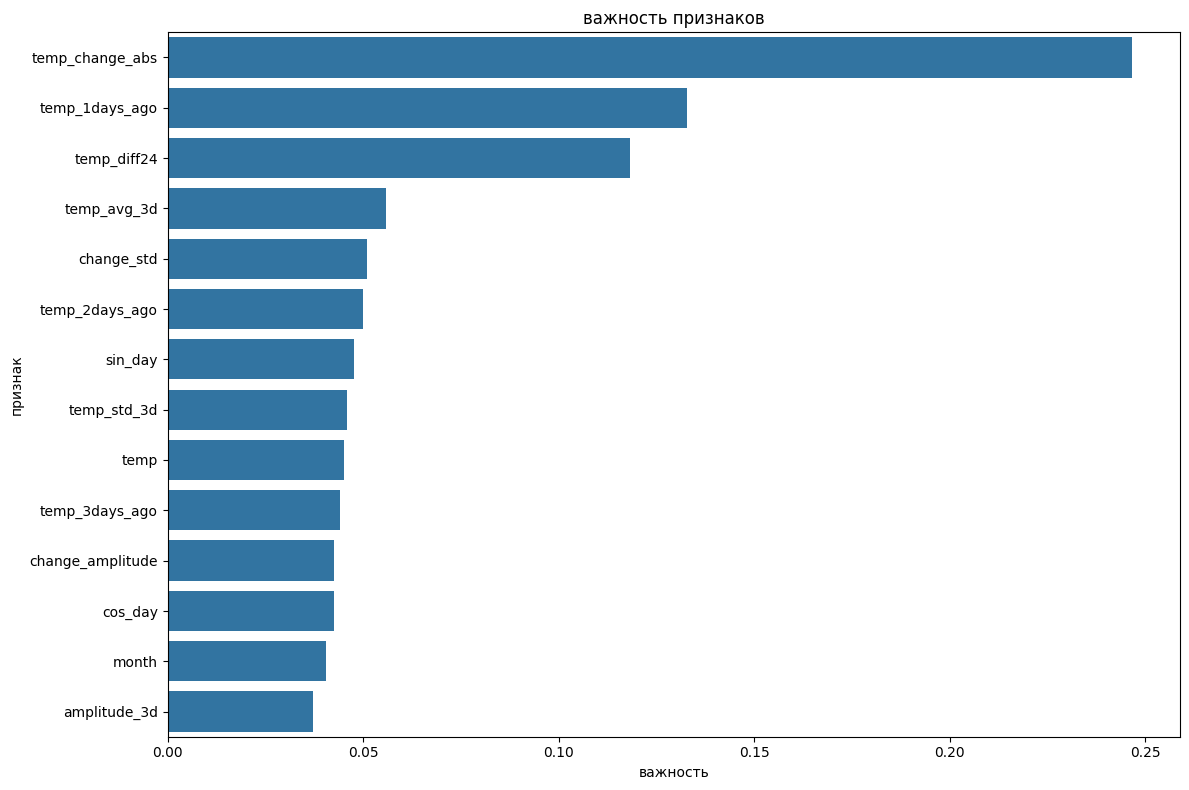

In [16]:
feature_importance=pd.DataFrame(
    {
        'feature':X_train.columns,
        'importance':xgb.feature_importances_
    }
).sort_values('importance',ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=feature_importance,x='importance',y='feature')
plt.title('важность признаков')
plt.xlabel('важность')
plt.ylabel('признак')

plt.tight_layout()
plt.show()